# Обучение с учителем: качество модели

## Цель исследования

Разработать модель машинного обучения, которая сможет предсказывать предпочтения и покупательскую активность постоянных клиентов интернет-магазина «В один клик» на основе их предыдущих покупок. Это позволит персонализировать предложения, повысить вовлечённость пользователей и увеличить их лояльность к магазину.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.  



## Описание данных 

`market_file.csv` - Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

| Столбец | Обозначение |
| ------- | ------- |
| `id` | номер покупателя в корпоративной базе данных. |
| `Покупательская активность` |  рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень». |
| `Тип сервиса` | уровень сервиса, например «премиум» и «стандарт». |
| `Разрешить сообщать` | нформация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель. |
| `Маркет_актив_6_мес` | среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента. |
| `Маркет_актив_тек_мес` | количество маркетинговых коммуникаций в текущем месяце. |
| `Длительность` |  значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте. |
| `Акционные_покупки` | среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев. |
| `Популярная_категория` | самая популярная категория товаров у покупателя за последние 6 месяцев. |
| `Средний_просмотр_категорий_за_визит` | показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца. |
| `Неоплаченные_продукты_штук_квартал` |  общее число неоплаченных товаров в корзине за последние 3 месяца. |
| `Ошибка_сервиса` | число сбоев, которые коснулись покупателя во время посещения сайта. |
| `Страниц_за_визит` | среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца. |


`market_money.csv` - Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом. 

| Столбец | Обозначение |
| ------- | ------- |
| `id` | номер покупателя в корпоративной базе данных. |
| `Период` | название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'. |
| `Выручка` | сумма выручки за период. |


`market_time.csv` — Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

| Столбец | Обозначение |
| ------- | ------- |
| `id` | номер покупателя в корпоративной базе данных. |
| `Период` |  название периода, во время которого зафиксировано общее время. |
| `минут` | значение времени, проведённого на сайте, в минутах. |


`money.csv` — Таблица с данными о среднемесячной прибыли продавца за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

| Столбец | Обозначение |
| ------- | ------- |
| `id` | номер покупателя в корпоративной базе данных. |
| `Прибыль` |  значение прибыли. |


# Обзор данных

## Установка дополнительных библиотек

In [1]:
#!pip install phik shap -q

## Импортирование библиотек

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor

from phik import phik_matrix
import shap

# Настройки отображения
pd.set_option('display.max_columns', None)
sns.set_theme(style="darkgrid")

## Считывание данных из CSV

In [3]:
try:
    data_market_file = pd.read_csv('market_file.csv')
    data_market_money = pd.read_csv('market_money.csv')
    data_market_time = pd.read_csv('market_time.csv')
    data_money = pd.read_csv('money.csv')
except:
    data_market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
    data_market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
    data_market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
    data_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv')
    
for name, df in [('data_market_file', data_market_file), ('data_market_money', data_market_money), ('data_market_time', data_market_time), ('data_money', data_money)]:
    f'\n{name}'
    display(df.head())
    display(df.info())
    display(df.describe())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

None

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


None

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


None

,id,минут
count,2600.000000,2600.000000
mean,215997.500000,13.336154
std,375.349754,4.080198
min,215348.000000,4.000000
25%,215672.750000,10.000000
50%,215997.500000,13.000000
75%,216322.250000,16.000000
max,216647.000000,23.000000


,id;Прибыль
215348;0,98.0
215349;4,16.0
215350;3,13.0
215351;4,87.0
215352;4,21.0


<class 'pandas.core.frame.DataFrame'>
Index: 1300 entries, 215348;0 to 216647;3
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id;Прибыль  1284 non-null   float64
dtypes: float64(1)
memory usage: 20.3+ KB


None

,id;Прибыль
count,1284.000000
mean,45.379283
std,30.388371
min,1.000000
25%,16.000000
50%,43.500000
75%,72.250000
max,99.000000


Данные загружены, выбивающихся значений не обнаружено. в данных из файла money.csv указан разделитель ";". В data_money у признака "прибыль" указан неверный тип данных.

Перезагрузим данные из этого файла с правильным разделителем.

In [4]:
try:
    data_money = pd.read_csv('/datasets/money.csv', sep=';')  
except:
    data_money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';')

data_money['Прибыль'] = data_money['Прибыль'].str.replace(',', '.').astype(float)

display(data_money.head())
display(data_money.info())
display(data_money.describe())

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


None

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


## Приведение именования столбцов к общей стилистике

### data_market_file

In [5]:
columns = {
    'Покупательская активность': 'активность_покупателя',
    'Тип сервиса': 'тип_сервиса', 
    'Разрешить сообщать': 'разрешение_рассылки',
    'Маркет_актив_6_мес': 'маркетинговая_активность_6мес',
    'Маркет_актив_тек_мес': 'маркетинговая_активность_текущий_мес',
    'Длительность': 'дней_с_регистрации',
    'Акционные_покупки': 'доля_акционных_покупок',
    'Популярная_категория': 'популярная_категория',
    'Средний_просмотр_категорий_за_визит': 'среднее_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал': 'неоплаченные_товары_квартал',
    'Ошибка_сервиса': 'ошибки_сервиса',
    'Страниц_за_визит': 'страниц_за_визит'
}

data_market_file = data_market_file.rename(columns=columns)
data_market_file.columns

Index(['id', 'активность_покупателя', 'тип_сервиса', 'разрешение_рассылки',
       'маркетинговая_активность_6мес', 'маркетинговая_активность_текущий_мес',
       'дней_с_регистрации', 'доля_акционных_покупок', 'популярная_категория',
       'среднее_категорий_за_визит', 'неоплаченные_товары_квартал',
       'ошибки_сервиса', 'страниц_за_визит'],
      dtype='object')

### data_market_money

In [6]:
columns = {
    'Период': 'период',
    'Выручка': 'выручка'
}

data_market_money = data_market_money.rename(columns=columns)
data_market_money.columns

Index(['id', 'период', 'выручка'], dtype='object')

### data_market_time

In [7]:
columns = {
    'Период': 'период', 
    'минут': 'минут_на_сайте'
}

data_market_time = data_market_time.rename(columns=columns)
data_market_time.columns

Index(['id', 'период', 'минут_на_сайте'], dtype='object')

###  data_money

In [8]:
columns = {
    'Прибыль': 'прибыль'
}

data_money = data_money.rename(columns=columns)
data_money.columns

Index(['id', 'прибыль'], dtype='object')

## Промежуточный вывод

Были установленны дополнительные и импортированы библиотеки для работы, загружены данные из файлов. Пропущенных значений нет. При чтении данных из файла money.csv было обнаружено, что в нем указан неверный разделитель. Это было исправлено путем перезагрузки файла и указания нужного разделителя. Названия признаков приведены к единому стилю.

# Предобработка данных

## Проверка на явные будликаты

In [9]:
for df, name in [(data_market_file, "market_file"),
          (data_market_money, "market_money"), 
          (data_market_time, "market_time"),
          (data_money, "money")]:
    
    duplicates = df.duplicated().sum()
    
    print(f"\nДатафрейм: {name}")
    display(duplicates)
    
    if duplicates > 0:
        duplicates = df[df.duplicated(keep=False)]
        display(duplicates)
    


Датафрейм: market_file


0


Датафрейм: market_money


0


Датафрейм: market_time


0


Датафрейм: money


0

Явные дубликаты во всех датафреймах отсутствуют.

## Проверка на неявные дубликаты категориальх признаков в data_market_file

In [10]:
columns = ['активность_покупателя', 'тип_сервиса', 'разрешение_рассылки', 'популярная_категория']

for col in columns:
    print('\n', col)
    display(data_market_file[col].unique())


 активность_покупателя


array(['Снизилась', 'Прежний уровень'], dtype=object)


 тип_сервиса


array(['премиум', 'стандартт', 'стандарт'], dtype=object)


 разрешение_рассылки


array(['да', 'нет'], dtype=object)


 популярная_категория


array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

В признаке "тип_сервиса" ошибка в написании "стандарт" с двумя буквами "т" и в слове "аксесуары" пропущена "с"

In [11]:
data_market_file['тип_сервиса'] = data_market_file['тип_сервиса'].str.replace('стандартт', 'стандарт')
data_market_file['популярная_категория'] = data_market_file['популярная_категория'].str.replace('Косметика и аксесуары', 'Косметика и аксессуары')
display(data_market_file['тип_сервиса'].unique())
display(data_market_file['популярная_категория'].unique())

array(['премиум', 'стандарт'], dtype=object)

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксессуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

## Проверка на неявные дубликаты в data_market_money

In [12]:
data_market_money['период'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

## Проверка на неявные дубликаты в data_market_time

In [13]:
data_market_time['период'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Ошибка в написании "предыдцщий_месяц"

In [14]:
data_market_time['период'] = data_market_time['период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
data_market_time['период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

## Промежуточный вывод

На этапе предобработки данных явных дубликатов не обнаружено. При проверке на неявные дубликаты было выявленно следующее:
1. в файле data_market_file:
- В признаке "тип_сервиса" ошибка в написании "стандарт" с двумя буквами "т" и в слове "аксесуары" пропущена "с" в признаке "популярная_категори"

2. в файле data_market_money:
- Ошибка в написании "предыдущий_месяц" в признаке "период"

3. в файле data_market_time:
- Ошибка в написании "предыдцщий_месяц" в признаке "период"

Все ошибки были исправлены.

# Исследовательский анализ данных

## Определим функцию для построения гистограммы по определенному параметру и вывода основной статистики

In [15]:
def show_hist(data, column, bins=30):
    """
    Строит гистограмму и boxplot для указанного столбца DataFrame, 
    выводит основные статистические параметры, отмечает 99-й перцентиль,
    а также показывает количество значений, превышающих 99-й перцентиль, и их долю.

    params:
    data (DataFrame): Исходный датафрейм.
    column (str): Название признака для анализа.
    bins (int, optional): Количество бинов гистограммы. По умолчанию 30.

    return: None
    """
    
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Вычисление статистики
    percentile_99 = data[column].quantile(0.99)
    count_above_99 = data[data[column] > percentile_99][column].count()
    total_count = data[column].count()
    proportion_above_99 = count_above_99 / total_count
    
    print(f"\nСтатистика для '{column}':")
    print(f"Количество значений: {total_count}")
    print(f"Минимум: {data[column].min()}")
    print(f"Максимум: {data[column].max()}")
    print(f"Среднее: {data[column].mean():.2f}")
    print(f"Медиана: {data[column].median():.2f}")
    print(f"Стандартное отклонение: {data[column].std():.2f}")
    print(f"99-й перцентиль: {percentile_99:.2f}")
    print(f"Количество значений выше 99-го перцентиля: {count_above_99}")
    print(f"Доля значений выше 99-го перцентиля: {proportion_above_99:.2%}")

    # Создаём фигуру с 2 графиками: гистограмма + boxplot
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [3, 1]})

    # Гистограмма с линией 99-го перцентиля
    sns.histplot(data[column], bins=bins, kde=True, color="blue", alpha=0.7, ax=axes[0])
    axes[0].axvline(percentile_99, color='red', linestyle='dashed', linewidth=2, label="99-й перцентиль")
    axes[0].legend()
    axes[0].set_xlabel(column)
    axes[0].set_ylabel("Частота")
    axes[0].set_title(f"Гистограмма для '{column}'")
    axes[0].grid(True)

    # Boxplot
    sns.boxplot(x=data[column], ax=axes[1], color="lightblue")
    axes[1].axvline(percentile_99, color='red', linestyle='dashed', linewidth=2)
    axes[1].set_xlabel(column)
    axes[1].set_title("Диаграмма размаха")

    plt.tight_layout()
    plt.show()

## Определим функцию для построения круговой диаграммы по определенному признаку

In [16]:
def show_pie(data, column, autopct='%1.1f%%'):
    """
    Строит круговую диаграмму для указанного категориального признака.
    
    params:
    data: DataFrame
    column: имя столбца (str)
    autopct: формат отображения процентов
    """
    
    import matplotlib.pyplot as plt
    
    value_counts = data[column].value_counts()
    
    plt.figure(figsize=(6, 6))
    plt.pie(value_counts, labels=value_counts.index, autopct=autopct, startangle=90)
    plt.title(f'Распределение: {column}')
    plt.axis('equal')  
    plt.tight_layout()
    plt.show()

##  Отбор клиентов с покупательской активностью не менее трёх месяцев

In [17]:
active_clients = data_market_money[data_market_money['выручка'] > 0].groupby('id').size()
active_clients = active_clients[active_clients >= 3].index.tolist()

data_market_file = data_market_file[data_market_file['id'].isin(active_clients)]
data_market_money = data_market_money[data_market_money['id'].isin(active_clients)]
data_market_time = data_market_time[data_market_time['id'].isin(active_clients)]
data_money = data_money[data_money['id'].isin(active_clients)]

## Анализ данных data_market_file

### Диаграмма для признака активность_покупателя                  

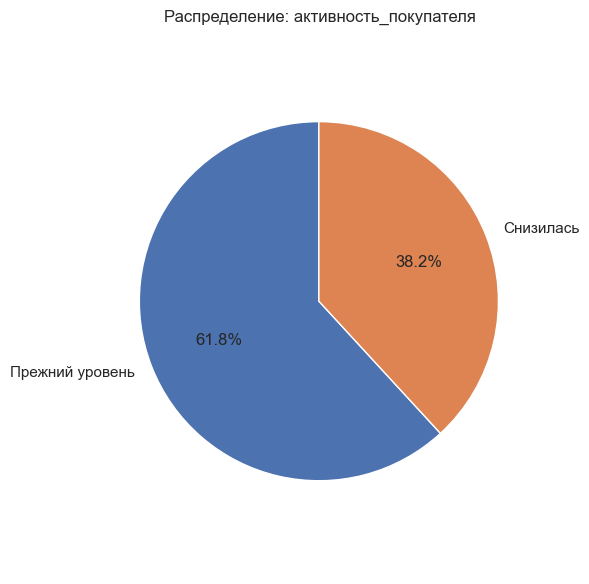

In [18]:
show_pie(data_market_file, 'активность_покупателя')

На данный момент, покупательская активность с прежним уровнем составляет 61.8%

### Диаграмма для признака тип_сервиса

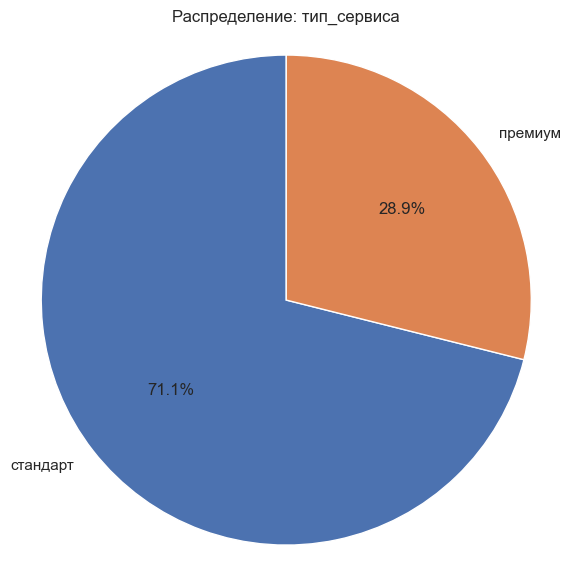

In [19]:
show_pie(data_market_file, 'тип_сервиса')

Количество клиентов с премиальным обслуживанием составляет 28.9%. Почти треть от общего числа.

### Диаграмма для признака разрешение_рассылки

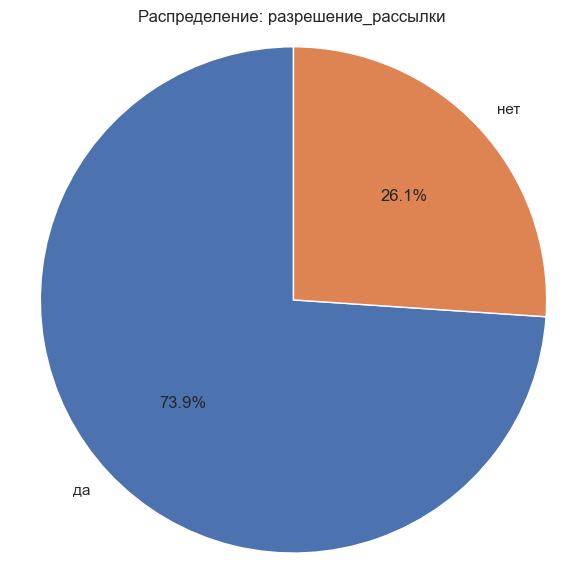

In [20]:
show_pie(data_market_file, 'разрешение_рассылки')

Почти 74% клиентов согласны на получение дополнительных предложений.

### Гистограмма для признака маркетинговая_активность_6мес


Статистика для 'маркетинговая_активность_6мес':
Количество значений: 1297
Минимум: 0.9
Максимум: 6.6
Среднее: 4.25
Медиана: 4.20
Стандартное отклонение: 1.02
99-й перцентиль: 6.30
Количество значений выше 99-го перцентиля: 12
Доля значений выше 99-го перцентиля: 0.93%


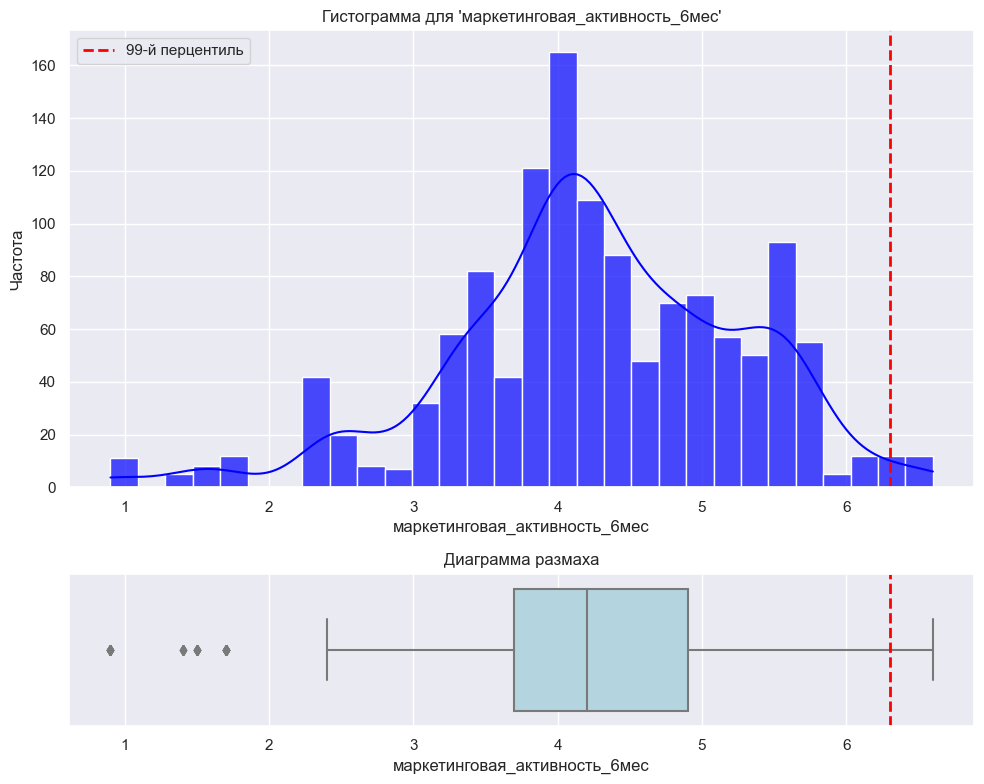

In [21]:
show_hist(data_market_file, 'маркетинговая_активность_6мес')

Медиана: 4.20 (близка к среднему: 4.25, что указывает на симметричное распределение). Крайне низкая активность (менее 2) встречается редко.

### Гистограмма для признака маркетинговая_активность_текущий_мес

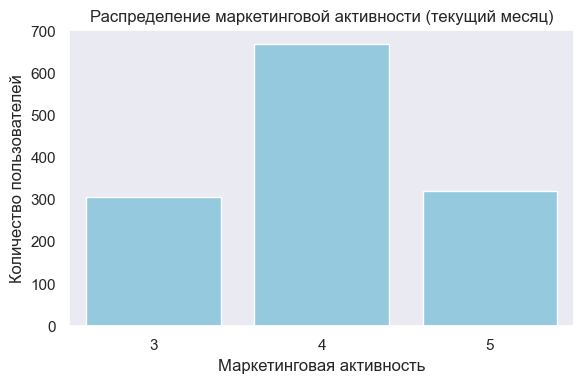

In [22]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data_market_file, x='маркетинговая_активность_текущий_мес', color='skyblue')

plt.title("Распределение маркетинговой активности (текущий месяц)")
plt.xlabel("Маркетинговая активность")
plt.ylabel("Количество пользователей")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Больше всего маркетинговых коммуникаций - 4.

### Гистограмма для признака дней_с_регистрации


Статистика для 'дней_с_регистрации':
Количество значений: 1297
Минимум: 121
Максимум: 1079
Среднее: 602.99
Медиана: 607.00
Стандартное отклонение: 249.10
99-й перцентиль: 1051.00
Количество значений выше 99-го перцентиля: 12
Доля значений выше 99-го перцентиля: 0.93%


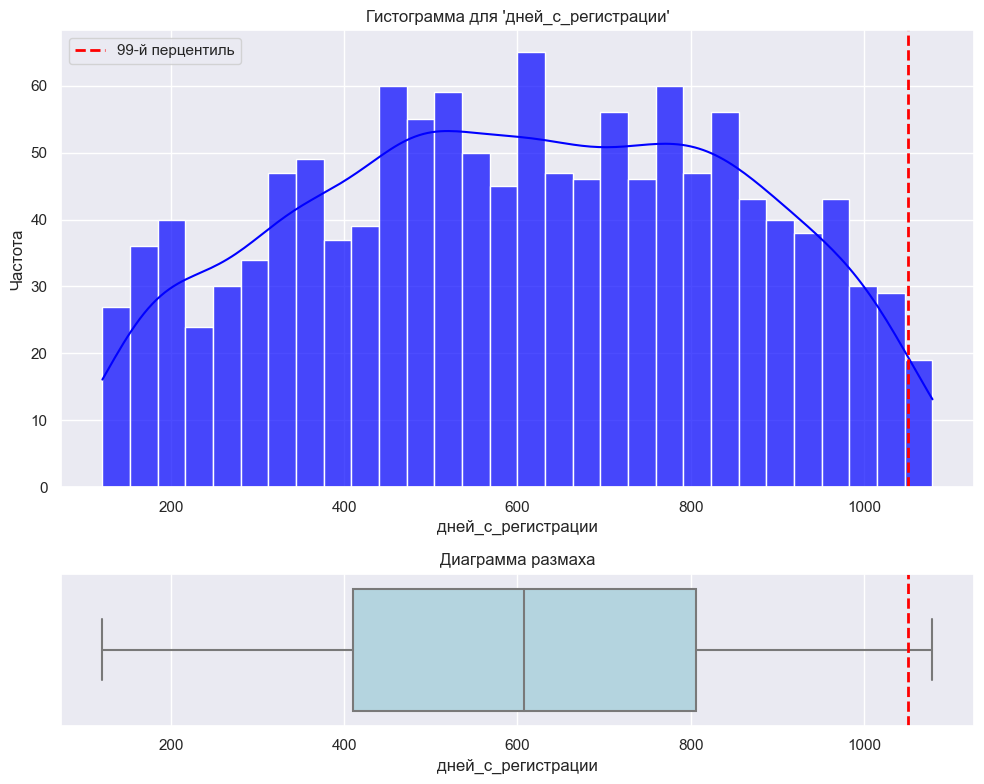

In [23]:
show_hist(data_market_file, 'дней_с_регистрации')

Распределение близко к нормальному. Медиана почти идентична среднему. Диапазон значений составляет примерно 3 года. Отсутствуют новые клиенты (более 3-х месяцев нет новых пользователей).

### Гистограмма для признака доля_акционных_покупок


Статистика для 'доля_акционных_покупок':
Количество значений: 1297
Минимум: 0.11
Максимум: 0.99
Среднее: 0.32
Медиана: 0.24
Стандартное отклонение: 0.25
99-й перцентиль: 0.99
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


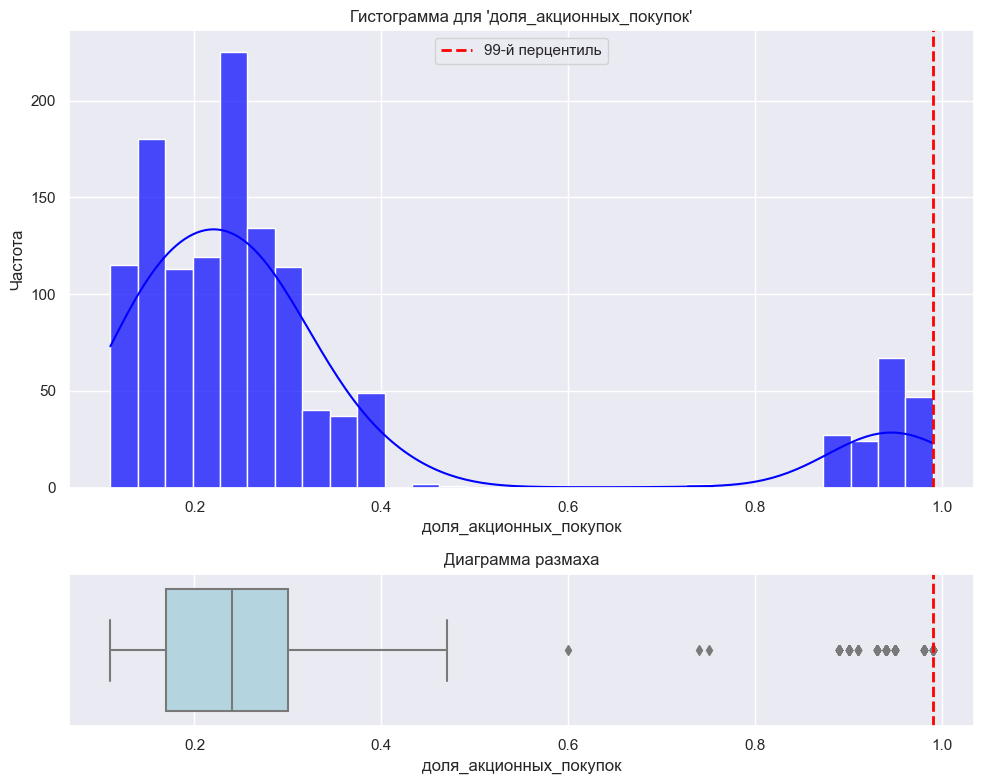

In [24]:
show_hist(data_market_file, 'доля_акционных_покупок')

Очень малая доля клиентов не совершает покупки по акции. Доля покупок большинства клиентов находится в диапазоне от 0.18 до 0.3 (примерно). Есть небольшое количество покупателей, которые совершают покупки по акциям в большинстве случаев. 

### Диаграмма для признака популярная_категория

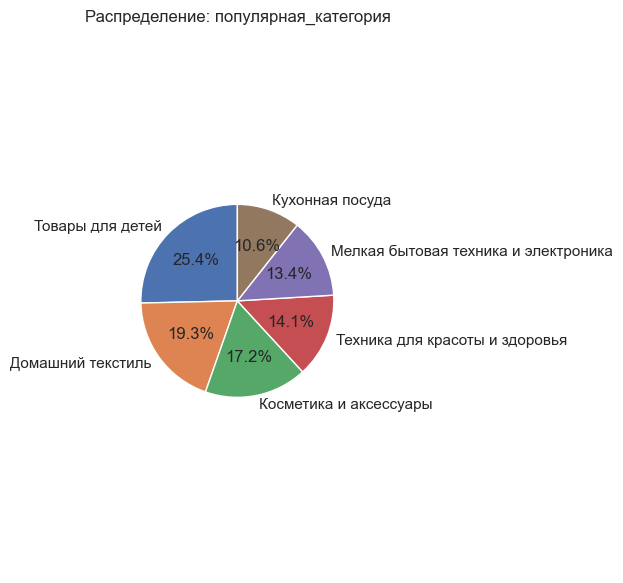

In [25]:
show_pie(data_market_file, 'популярная_категория')

Топ-3 категорий:
- Товары для детей - 25.4%
- Домашний текстиль - 19.3%
- Косметика и аксессуары - 17.2%
  
Самая не популярная категория - Кухонная посуда, всего 10.6%

### Гистограмма для признака среднее_категорий_за_визит


Статистика для 'среднее_категорий_за_визит':
Количество значений: 1297
Минимум: 1
Максимум: 6
Среднее: 3.27
Медиана: 3.00
Стандартное отклонение: 1.35
99-й перцентиль: 6.00
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


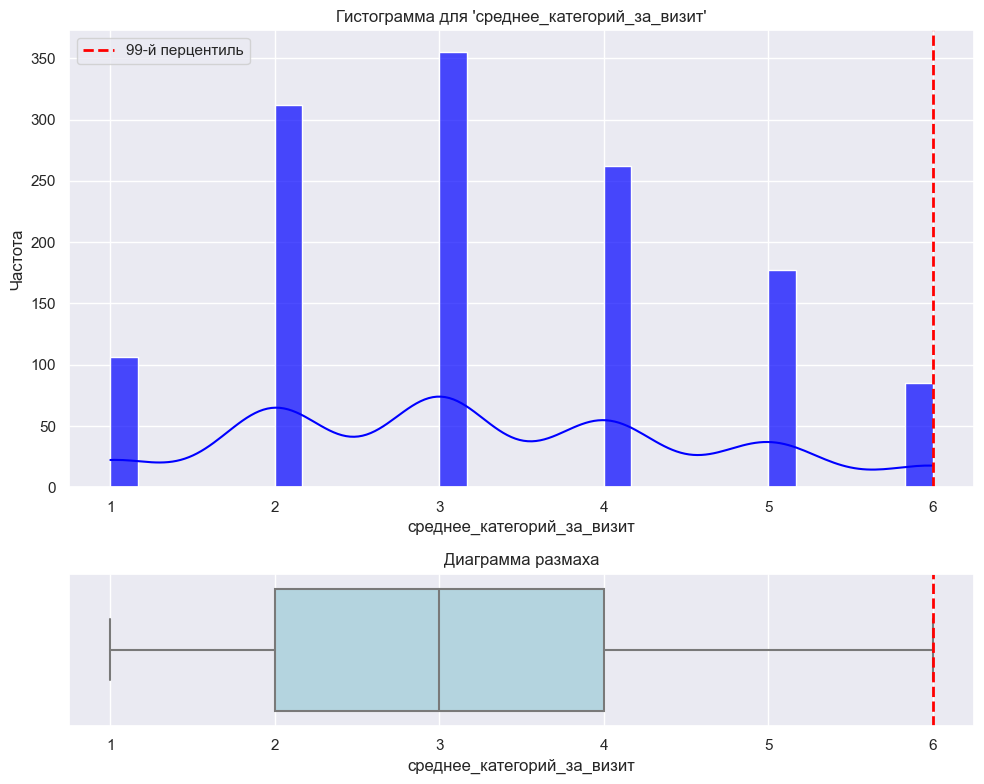

In [26]:
show_hist(data_market_file, 'среднее_категорий_за_визит')

Распределение близко к нормальному. Медиана и среднее практически идентичны. В среднем, клиенты просматривают 3 категории за визит на сайт.

### Гистограмма для признака неоплаченные_товары_квартал


Статистика для 'неоплаченные_товары_квартал':
Количество значений: 1297
Минимум: 0
Максимум: 10
Среднее: 2.84
Медиана: 3.00
Стандартное отклонение: 1.97
99-й перцентиль: 9.00
Количество значений выше 99-го перцентиля: 4
Доля значений выше 99-го перцентиля: 0.31%


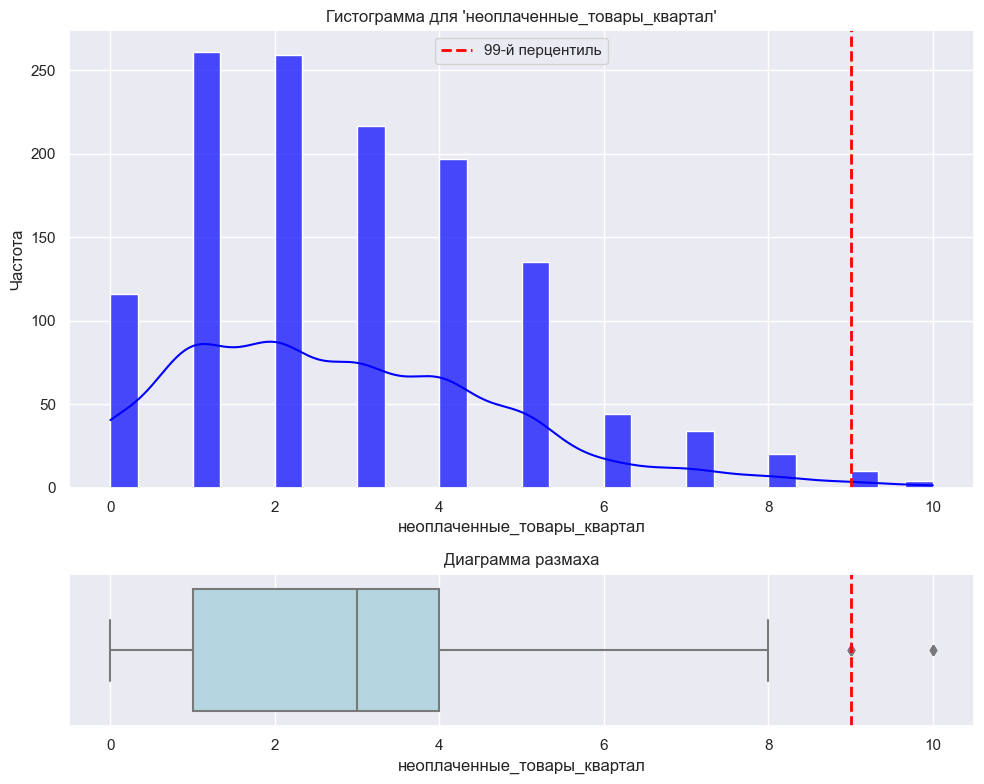

In [27]:
show_hist(data_market_file, 'неоплаченные_товары_квартал')

Среднее количество неоплаченных товаров в корзине практически равно 3. Длинный хвост уходящий право указывает, что есть небольшое число клиентов, у которых в корзине больше 6 товаров.

### Гистограмма для признака ошибки_сервиса


Статистика для 'ошибки_сервиса':
Количество значений: 1297
Минимум: 0
Максимум: 9
Среднее: 4.18
Медиана: 4.00
Стандартное отклонение: 1.95
99-й перцентиль: 9.00
Количество значений выше 99-го перцентиля: 0
Доля значений выше 99-го перцентиля: 0.00%


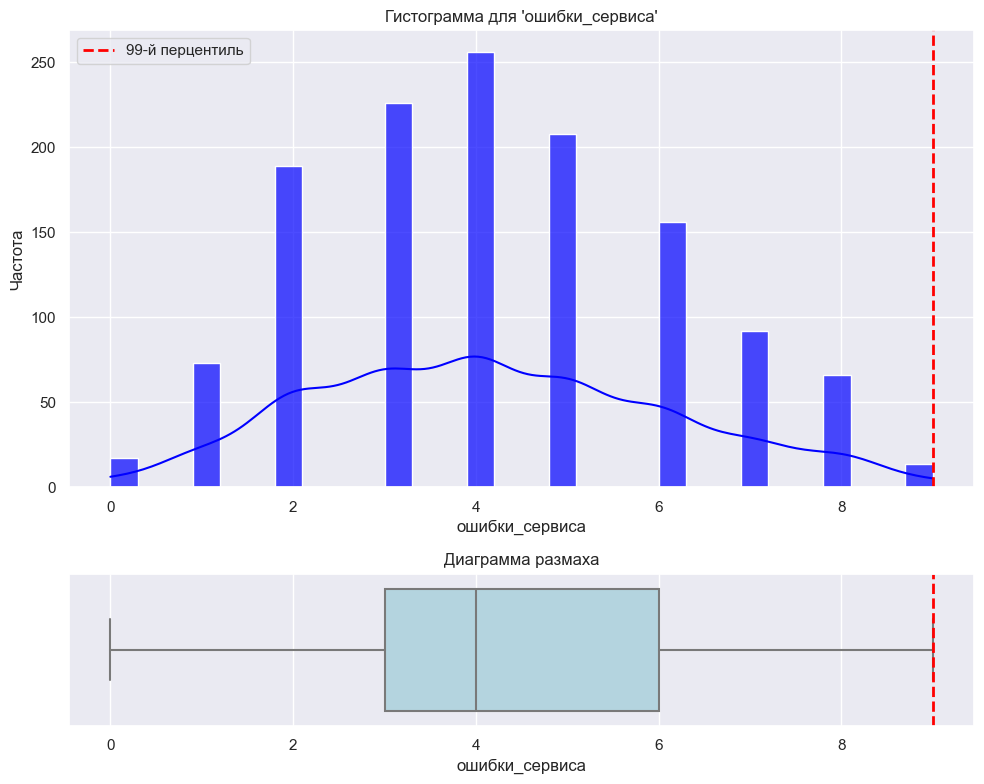

In [28]:
show_hist(data_market_file, 'ошибки_сервиса')

Данные распределены нормально. Среднее количество сбоев практически соответствует медиане (4). 

### Гистограмма для признака страниц_за_визит


Статистика для 'страниц_за_визит':
Количество значений: 1297
Минимум: 1
Максимум: 20
Среднее: 8.19
Медиана: 8.00
Стандартное отклонение: 3.98
99-й перцентиль: 18.00
Количество значений выше 99-го перцентиля: 7
Доля значений выше 99-го перцентиля: 0.54%


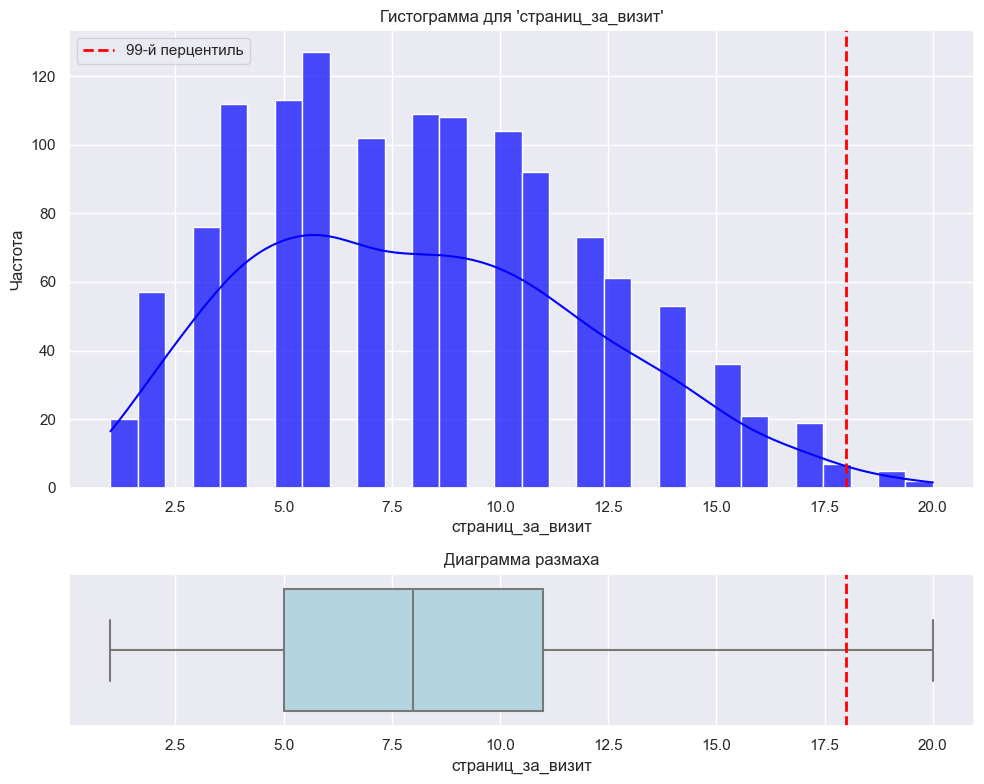

In [29]:
show_hist(data_market_file, 'страниц_за_визит')

В среднем, пользователи просматривают около 8 страниц за визит на сайт. Большая часть клиентов просматривают от 5 до 11 страниц. 

## Анализ данных data_market_money

### Диаграмма суммарной выручки по периодам

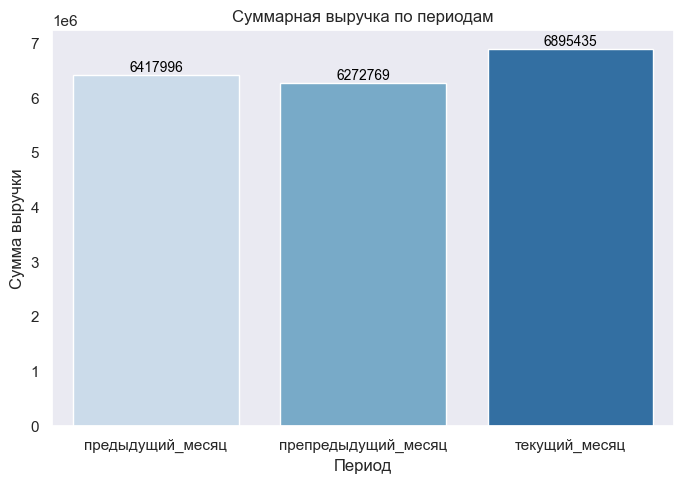

In [30]:
revenue_by_period = data_market_money.groupby('период', as_index=False)['выручка'].sum()
plt.figure(figsize=(7, 5))
sns.barplot(data=revenue_by_period, x='период', y='выручка', palette='Blues')

for index, row in revenue_by_period.iterrows():
    plt.text(index, row['выручка'], f"{row['выручка']:.0f}", 
             color='black', ha='center', va='bottom', fontsize=10)

plt.title("Суммарная выручка по периодам")
plt.xlabel("Период")
plt.ylabel("Сумма выручки")
plt.grid(axis='y')
plt.tight_layout()

В текущем месяце была самая большая выручка за эти 3 месяца

### Гистограмма для признака выручка


Статистика для 'выручка':
Количество значений: 3891
Минимум: 2758.7
Максимум: 106862.2
Среднее: 5033.72
Медиана: 4959.00
Стандартное отклонение: 1768.47
99-й перцентиль: 6958.07
Количество значений выше 99-го перцентиля: 39
Доля значений выше 99-го перцентиля: 1.00%


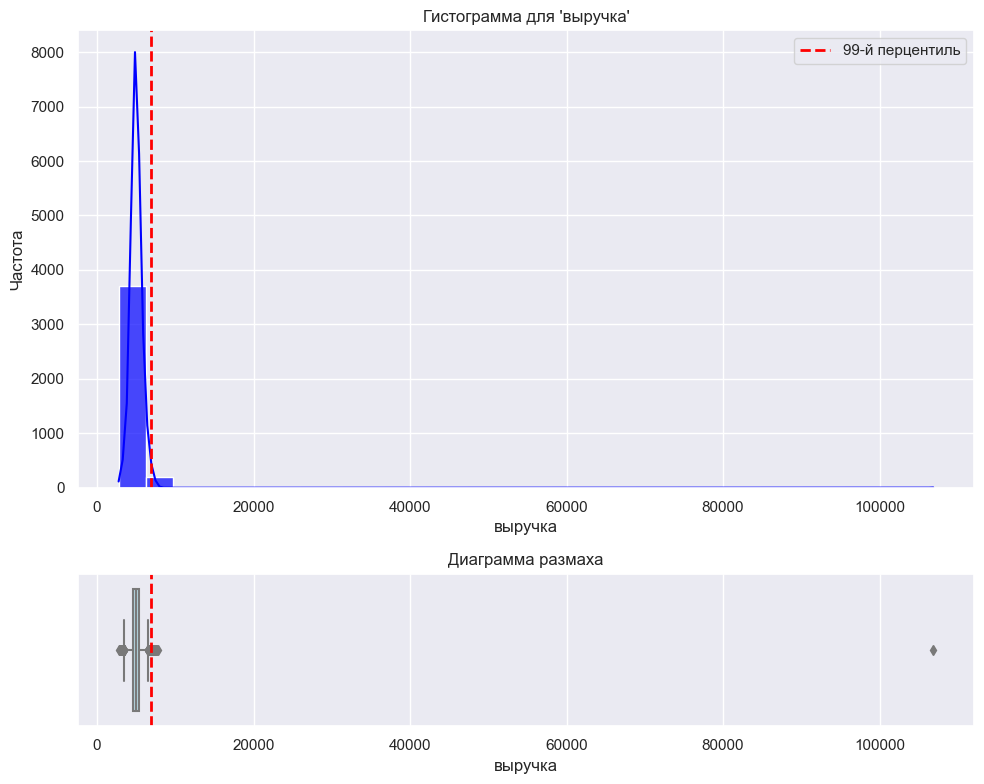

In [31]:
show_hist(data_market_money, 'выручка')

Одно аномальное значение, которое можно удалить.


Статистика для 'выручка':
Количество значений: 3890
Минимум: 2758.7
Максимум: 7799.4
Среднее: 5007.54
Медиана: 4959.00
Стандартное отклонение: 679.24
99-й перцентиль: 6939.90
Количество значений выше 99-го перцентиля: 39
Доля значений выше 99-го перцентиля: 1.00%


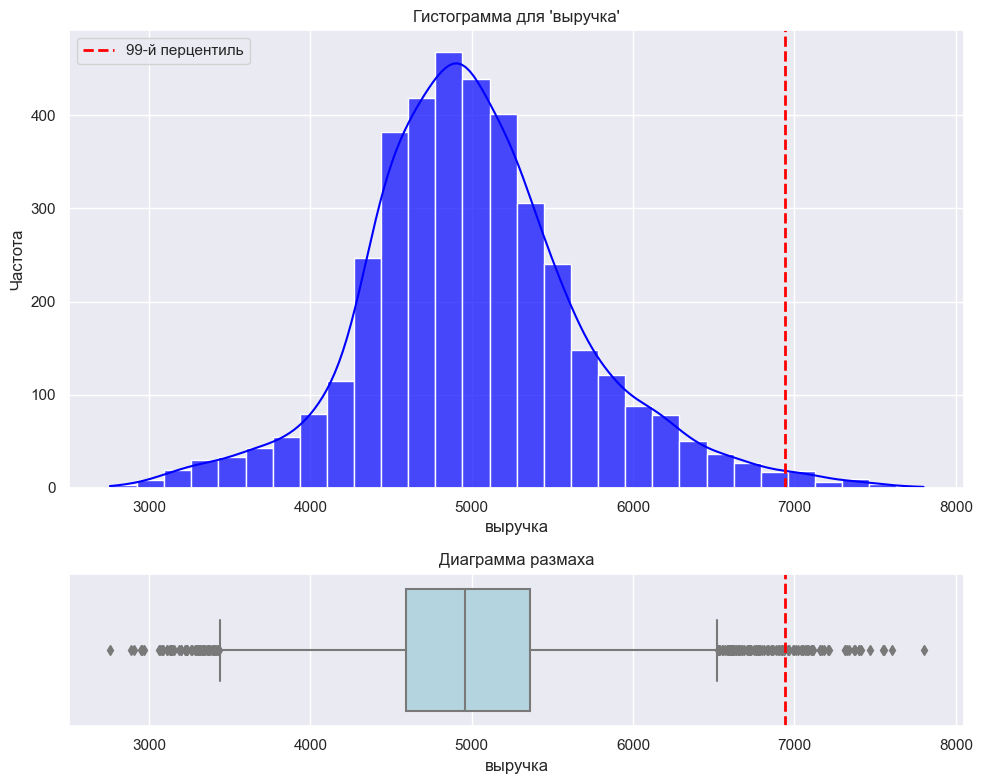

In [32]:
data_market_money = data_market_money.query('выручка < 20000')
show_hist(data_market_money, 'выручка')

Данные распределены нормально. Средняя выручка за период составляет около 5 тысяч.

## Анализ данных data_market_time

### Гистограмма суммарного времени на сайте по периодам.

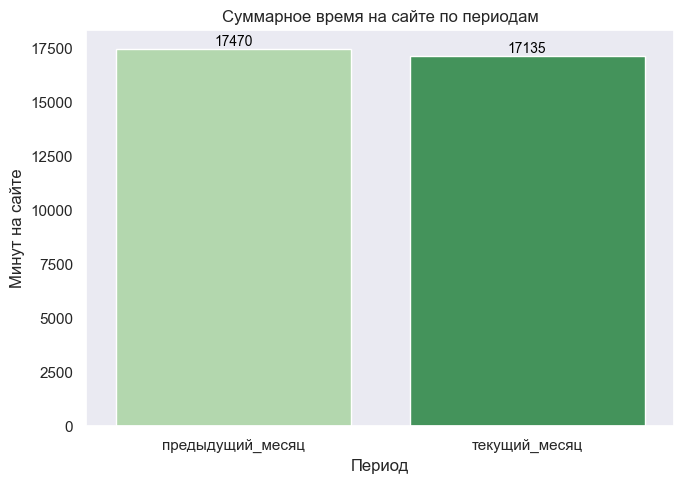

In [33]:
time_by_period = data_market_time.groupby('период', as_index=False)['минут_на_сайте'].sum()
plt.figure(figsize=(7, 5))
sns.barplot(data=time_by_period, x='период', y='минут_на_сайте', palette='Greens')

for index, row in time_by_period.iterrows():
    plt.text(index, row['минут_на_сайте'], f"{row['минут_на_сайте']:.0f}", 
             color='black', ha='center', va='bottom', fontsize=10)

plt.title("Суммарное время на сайте по периодам")
plt.xlabel("Период")
plt.ylabel("Минут на сайте")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Статистика для 'минут_на_сайте':
Количество значений: 2594
Минимум: 4
Максимум: 23
Среднее: 13.34
Медиана: 13.00
Стандартное отклонение: 4.08
99-й перцентиль: 22.00
Количество значений выше 99-го перцентиля: 14
Доля значений выше 99-го перцентиля: 0.54%


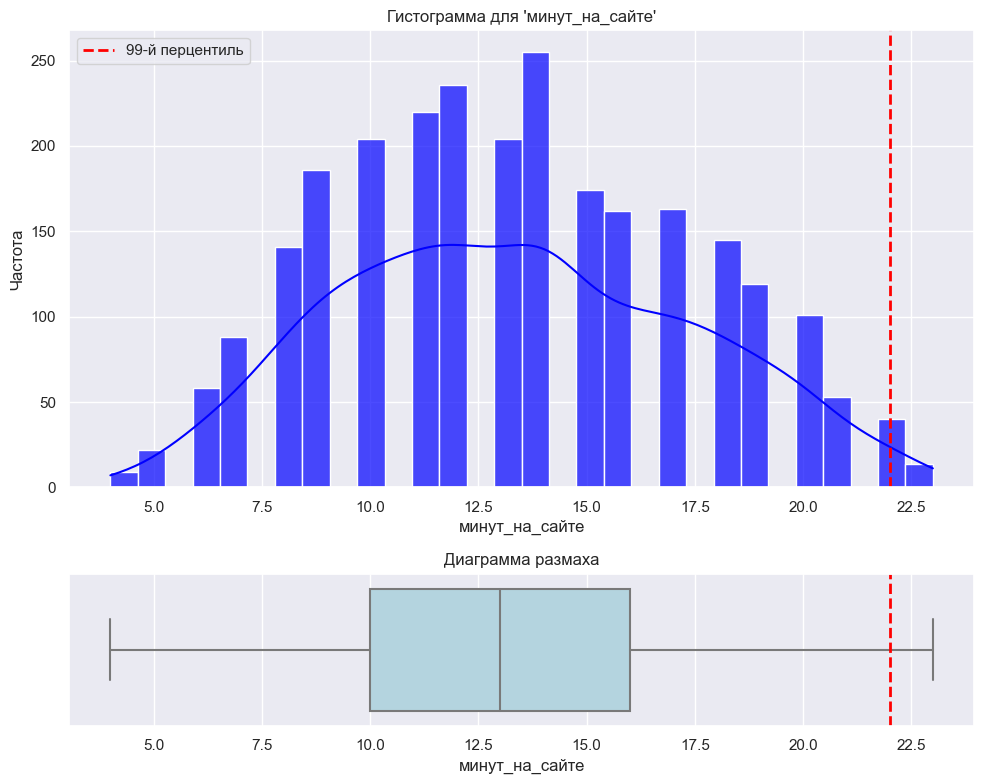

In [34]:
show_hist(data_market_time, 'минут_на_сайте')

В среднем, пользователи проводят на сайте около 13 минут.

## Анализ данных data_money

### Гистограмма для признака прибыль


Статистика для 'прибыль':
Количество значений: 1297
Минимум: 0.86
Максимум: 7.43
Среднее: 4.00
Медиана: 4.04
Стандартное отклонение: 1.01
99-й перцентиль: 6.40
Количество значений выше 99-го перцентиля: 13
Доля значений выше 99-го перцентиля: 1.00%


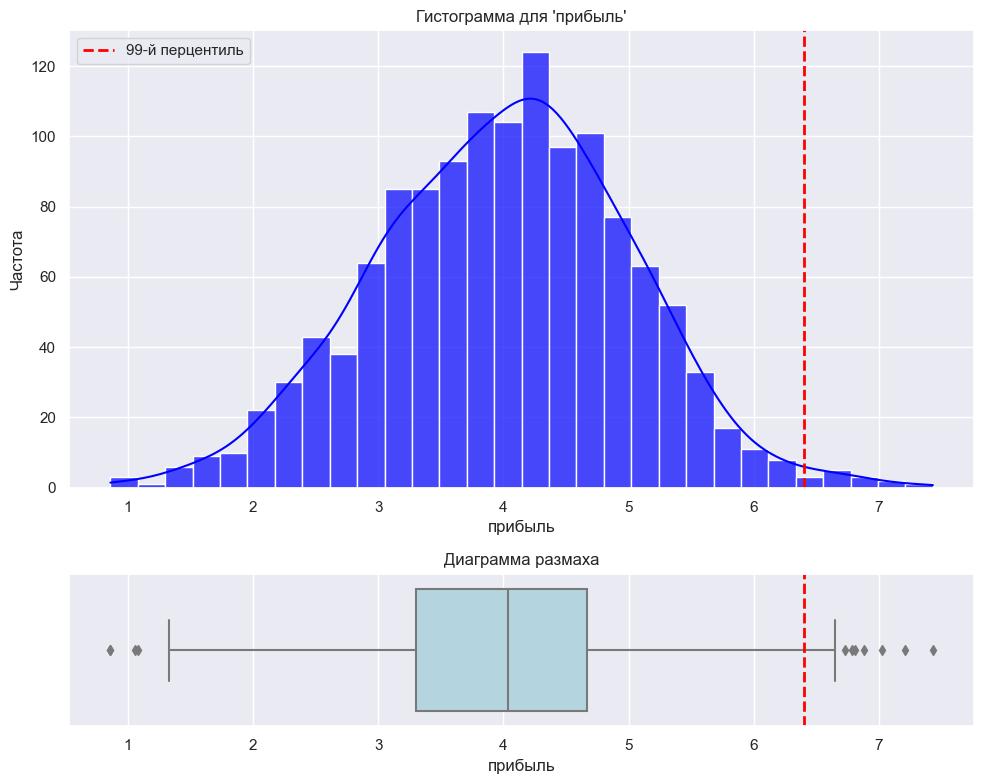

In [35]:
show_hist(data_money, 'прибыль')

## Промежуточный вывод

На данном этапе были определены функции для построения гистограммы, вывода основной статистики и построения круговой диаграммы. Отобраны клиенты с покупательской активностью не менее трёх месяцев.

Проанализированны данные data_market_file:
- активность покупателей с прежним уровнем составляет 61.8%
- количество клиентов с премиальным обслуживанием составляет 28.9%. Почти треть от общего числа.
- почти 74% клиентов согласны на получение дополнительных предложений.
- среднее значение маркетинговой активности около 4.
- средняя маркетинговая активность в текущем месяце также 4.
- новые пользователи отсутствуют на протяжении более 3-х месяцев.
- очень малая доля клиентов не совершает покупки по акции. Доля покупок большинства клиентов находится в диапазоне от 0.18 до 0.3 (примерно). Есть небольшое количество покупателей, которые совершают покупки по акциям в большинстве случаев.
- самая популярная категория - Товары для детей - 25.4%. Самая не популярная - Кухонная посуда, всего 10.6%.
- в среднем, клиенты просматривают 3 категории за визит на сайт.
- среднее количество неоплаченных товаров в корзине практически равно 3.
- среднее количество сбоев практически соответствует медиане (4).
- в среднем, пользователи просматривают около 8 страниц за визит на сайт. Большая часть клиентов просматривают от 5 до 11 страниц.

Проанализированны данные data_market_money:
- в текущем месяце только треть клиентов совершило покупки.
- средняя выручка за период составляет около 5 тысяч.

Проанализированны данные data_market_time:
- в среднем, пользователи проводят на сайте около 13 минут.

Проанализированны данные data_money:
- за последние 3 месяца средняя прибыль от продаж покупателю составляет 4 у.е.

# Объединение таблиц

In [36]:
data_market_time.columns

Index(['id', 'период', 'минут_на_сайте'], dtype='object')

In [37]:
data_market_money_grouped = data_market_money.groupby(['id', 'период'], as_index=False)['выручка'].mean()

revenue_pivot = data_market_money_grouped.pivot(index='id', columns='период', values='выручка')
revenue_pivot.columns = [f'выручка_{col}' for col in revenue_pivot.columns]
revenue_pivot = revenue_pivot.reset_index()

time_pivot = data_market_time.pivot(index='id', columns='период', values='минут_на_сайте')
time_pivot.columns = [f'время_{col}' for col in time_pivot.columns]
time_pivot = time_pivot.reset_index()

df_merged = data_market_file.merge(revenue_pivot, on='id', how='left')\
                            .merge(time_pivot, on='id', how='left')
df_merged.head()

,id,активность_покупателя,тип_сервиса,разрешение_рассылки,маркетинговая_активность_6мес,маркетинговая_активность_текущий_мес,дней_с_регистрации,доля_акционных_покупок,популярная_категория,среднее_категорий_за_визит,неоплаченные_товары_квартал,ошибки_сервиса,страниц_за_визит,выручка_предыдущий_месяц,выручка_препредыдущий_месяц,выручка_текущий_месяц,время_предыдущий_месяц,время_текущий_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,4738.5,5124.0,5388.5,10,10


## Промежуточный вывод

На этапе объединения таблиц мы объединили таблицы market_file.csv, market_money.csv, market_time.csv. Т.к. в data_market_money один и тот же клиент имеет несколько записей по одному и тому же периоду, их пришлось агрегировать и взять среднее значение.

# Корреляционный анализ

## Матрица корреляций количественных признаков

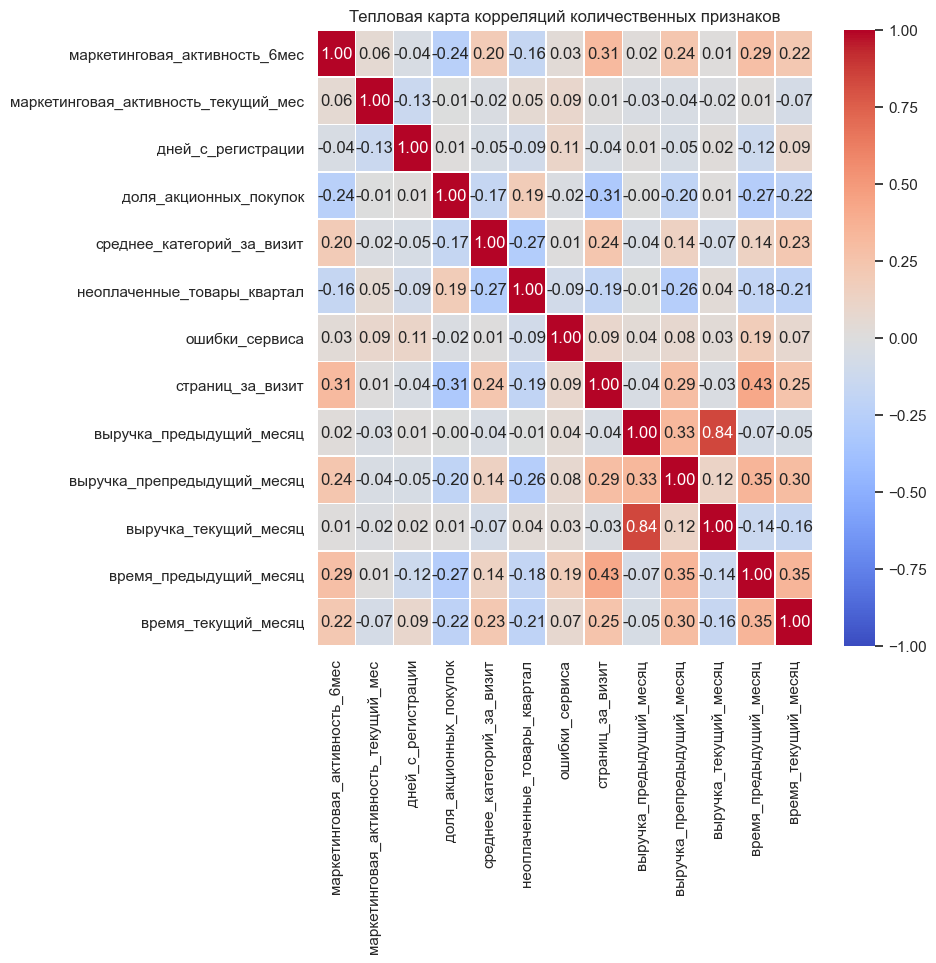

In [38]:
df_merged_num_cols = df_merged.select_dtypes(include=np.number).drop(columns=['id'])

correlation_matrix = df_merged_num_cols.corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, vmin=-1, vmax=1)
plt.title('Тепловая карта корреляций количественных признаков')
plt.show()

interval columns not set, guessing: ['маркетинговая_активность_6мес', 'маркетинговая_активность_текущий_мес', 'дней_с_регистрации', 'доля_акционных_покупок', 'среднее_категорий_за_визит', 'неоплаченные_товары_квартал', 'ошибки_сервиса', 'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц', 'время_предыдущий_месяц', 'время_текущий_месяц']


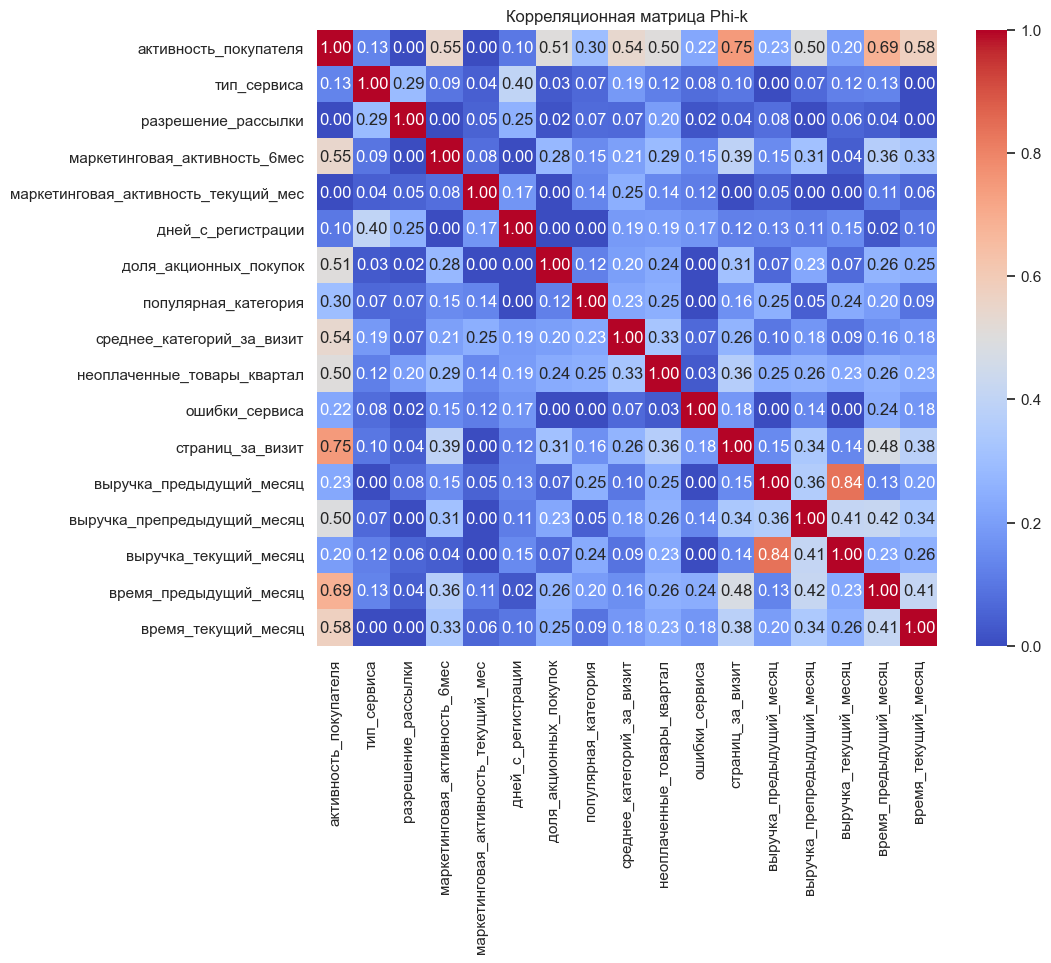

In [39]:
df_phik = df_merged.drop(columns='id')

phik_matrix = df_phik.phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=0, vmax=1)
plt.title("Корреляционная матрица Phi-k")
plt.show()

Принято считать, что мультиколлинеарность - когда коэффициент корреляции между двумя независимыми признаками по модулю превышает 0.7 - 0.8. 
На тепловой карте корреляций количественных признаков у признаков выручка_предыдущий_месяц и выручка_текущий_месяц - коэффициент корреляции 0.84.
Это значение превышает порог 0.8. Это означает, что выручка в текущем месяце сильно связана с выручкой в предыдущем месяце. Клиенты, которые приносили много выручки в прошлом месяце, вероятно, продолжат это делать и в текущем, или наоборот.

## Проверка на мультиколлинеарность

In [40]:
cols_for_vif = ['выручка_предыдущий_месяц', 'выручка_текущий_месяц']
X_vif = df_merged[cols_for_vif].dropna()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_vif)

vif_data = pd.DataFrame()
vif_data['Feature'] = cols_for_vif
vif_data['VIF'] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]

vif_data

,Feature,VIF
0,выручка_предыдущий_месяц,3.379524
1,выручка_текущий_месяц,3.379524


Все значения VIF ниже 3 — это значит, проблемы мультиколлинеарности в данных нет. VIF > 10 говорил бы о высокой мультиколлинеарности.

## Промежуточный вывод.

На этапе корреляционного анализа мы визуализировали матрицу корреляций количественных признаков. 
1. У признаков выручка_предыдущий_месяц и выручка_текущий_месяц - коэффициент корреляции 0.72. Значение указанных признаков больше 0.7, поэтому была проведена проверка этих признаков на мультиколлинеарность используя VIF. Значения VIF для выручка_предыдущий_месяц и выручка_текущий_месяц составляют примерно 2.1. Они находятся в диапазоне, который считается низким или умеренным уровнем мультиколлинеарности.
2. страниц_за_визит и время_предыдущий_месяц: 0.42. Чем больше страниц просматривает пользователь, тем больше времени он проводит на сайте.
3. время_предыдущий_месяц и время_текущий_месяц: 0.35. Небольшаяя положительная связь.
4. маркетинговая_активность_6мес и страниц_за_визит: 0.31.
5. доля_акционных_покупок и страниц_за_визит: -0.31. Пользователи, которые просматривают больше страниц, возможно, меньше сфокусированы на акционных товарах, или наоборот.

# Использование пайплайнов

## Определение списков столбцов

In [41]:
num_cols = ['маркетинговая_активность_6мес', 
            'дней_с_регистрации', 
            'доля_акционных_покупок', 
            'среднее_категорий_за_визит', 
            'неоплаченные_товары_квартал', 
            'ошибки_сервиса',
            'страниц_за_визит', 
            'выручка_предыдущий_месяц',
            'время_предыдущий_месяц',
            ]
ohe_cols = ['разрешение_рассылки', 'популярная_категория']
ord_cols = ['тип_сервиса']

## Разделение на выборки и кодирование целевого признака

In [42]:
X = df_merged.drop(['id', 'активность_покупателя', 'маркетинговая_активность_текущий_мес', 'выручка_текущий_месяц', 'время_текущий_месяц'], axis=1)
y = df_merged['активность_покупателя']

RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)

label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

## Пайплайн кодирования категорий

In [43]:
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
) 

## Пайплайн кодирования типа сервиса

In [44]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

## Пайплайн подготовки данных

In [45]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('ord', ord_pipe, ord_cols),
        ('num', MinMaxScaler(), num_cols)
    ], 
    remainder='passthrough'
) 

## Финальный пайплайн модели

In [46]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## Параметры для оптимизации

In [47]:
param_distributions = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 20), 
        'models__max_features': range(2, 20), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(1, 40), 
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

## Поиск лучшей модели и гиперпараметров

In [48]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

D:\anaconda\envs\practicum\lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              sparse_output=False))]),
                                                                               ['разрешение_рассылки',
                                                                                'популярная_категория']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_bef...
                                        {'models': [KNeighborsClassifier()],
                                         'models__n_neighbors': range(1, 40),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler()]},
                                        {'models': [SVC(probability=True,
                                                        random_state=42)],
                                         'models__C': [0.001, 0.01, 0.1, 1, 10,
                                                       100, 1000],
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

## Лучшая обученная модель

In [49]:
randomized_search.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['разрешение_рассылки',
                                                   'популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strate...
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['тип_сервиса']),
                                                 ('num', 'passthrough',
                                                  ['маркетинговая_активность_6мес',
                                                   'дней_с_регистрации',
                                                   'доля_акционных_покупок',
                                                   'среднее_категорий_за_визит',
                                                   'неоплаченные_товары_квартал',
                                                   'ошибки_сервиса',
                                                   'страниц_за_визит',
                                                   'выручка_предыдущий_месяц',
                                                   'время_предыдущий_месяц'])])),
                ('models',
                 SVC(C=1000, kernel='linear', probability=True,
                     random_state=42))])

## Лучший ROC AUC

In [50]:
randomized_search.best_score_

0.8912566333456745

## Лучшая комбинация гиперпараметров

In [51]:
randomized_search.best_params_

{'preprocessor__num': 'passthrough',
 'models__kernel': 'linear',
 'models__C': 1000,
 'models': SVC(probability=True, random_state=42)}

## Метрика на тестовой выборке

In [52]:
y_pred = randomized_search.predict(X_test)
y_proba = randomized_search.predict_proba(X_test)[:, 1]

print("ROC AUC:", roc_auc_score(y_test, y_proba))

ROC AUC: 0.9031655134017339


Метрика ROC AUC на тестовой выборке показала себя практически также, как и на тренировочной.

## Промежуточный вывод

На данном этапе мы обучили четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC() используя один общий пайплайн для всех моделей и инструмент подбора гиперпараметров. Во время определения списков были исключены признаки: 
- маркетинговая_активность_текущий_мес
- выручка_текущий_месяц
- время_текущий_месяц
Риск утечки данных с этими признаками велик, т.к. активность покупателя измеряется в текущем месяце и они включают действия, произошедшие в течение этого периода.

Наилучшие результаты показала модель SVC (Support Vector Classifier) со следующими характеристиками:

Гиперпараметры: kernel='linear', C=1000

Предобработка: масштабирование числовых признаков с помощью MinMaxScaler

Метрика качества: ROC AUC = 0.891

Метрика ROC AUC была выбрана т.к. она оценивает способность модели ранжировать экземпляры (покупателей) по вероятности принадлежности к положительному классу (активный покупатель), а не по предсказаниям, сделанным с фиксированным порогом и она эффективна при несбалансированных классах

# Анализ важности признаков

  0%|          | 0/20 [00:00<?, ?it/s]

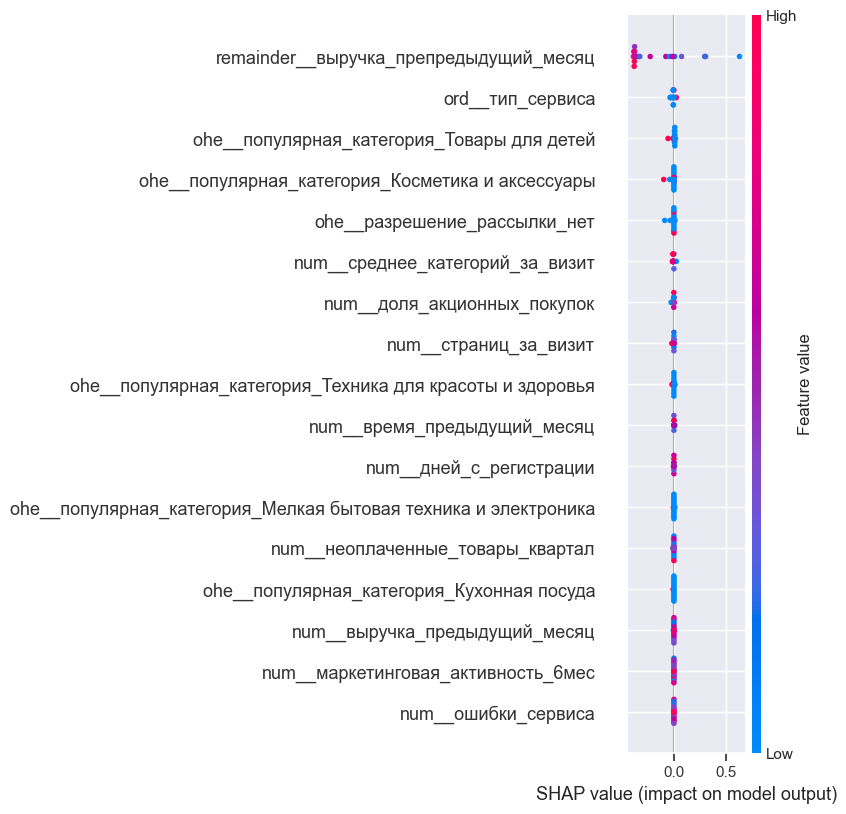

  0%|          | 0/20 [00:00<?, ?it/s]

In [53]:
shap.initjs()

X_train_shap = pd.DataFrame(
    data_preprocessor.fit_transform(X_train),
    columns=data_preprocessor.get_feature_names_out()
)
X_test_shap = pd.DataFrame(
    data_preprocessor.transform(X_test),
    columns=data_preprocessor.get_feature_names_out()
)

model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train_shap, y_train)

explainer = shap.KernelExplainer(model.predict_proba, X_train_shap[:20])

shap_values = explainer(X_test_shap[:20])

shap.summary_plot(shap_values[:, :,  1], X_test_shap[:20])

shap_values_array = explainer.shap_values(X_test_shap[:20])


## Промежуточный вывод

На данном этапе был построен график SHAP - значений для анализа важности признаков. 

Менее значимыми признаками оказались:
- ohe__популярная_категория_Кухонная посуда
- ohe__популярная_категория_Косметика и аксессуары 
- num__выручка_предыдущий_месяц
- ohe__популярная_категория_Техника для красоты и здоровья
- num__ошибки_сервиса
- ohe__популярная_категория_Товары для детей
- ohe__популярная_категория_Мелкая бытовая техника и электроника

Наиболее значимыми признаками оказались:
- num__среднее_категорий_за_визит - Чем больше категорий товаров пользователь просматривает в среднем за визит, тем выше вероятность положительного исхода
- num__время_предыдущий_месяц - Чем больше времени пользователь провел на сайте в предыдущем месяце, тем выше предсказание.
- num__доля_акционных_покупок
- num__страниц_за_визит
- num__маркетинговая_активность_6мес
- num__неоплаченные_товары_квартал

Малозначимые признаки можно попробовать исключить из модели. Это может упростить модель, сократить время обучения и иногда даже улучшить ее качество за счет уменьшения шума. Но перед удалением всегда стоит проверить, не ухудшится ли метрика качества модели. Понимая то, какие признаки важны, можно попробовать создать новые признаки. 

Бизнес может сосредоточить свои усилия на тех аспектах, которые сильнее всего влияют на целевой показатель. Стимулировать пользователей просматривать больше категорий и страниц за визит. Это может быть достигнуто через улучшение навигации, системы рекомендаций, персонализированного контента. Анализировать эффективность акций, возможно, персонализировать их. Работать над проблемой неоплаченных товаров. Оценить и оптимизировать маркетинговые кампании.

 На основе этих признаков можно выявлять сегменты клиентов с высоким или низким потенциалом для целевого действия и применять к ним разные стратегии. Если компания внедряет изменения (например, новый дизайн сайта для увеличения числа просмотренных страниц), то можно ожидать изменения в этих ключевых метриках и, как следствие, в целевом показателе.


# Сегментация покупателей

## Разделение клиентов на 2 категории, учитывая ключевые признаки.

In [54]:
pipe_final.fit(X_train, y_train)

df_merged['предсказанная_активность'] = pipe_final.predict(X)

important_features = [
    'среднее_категорий_за_визит',
    'время_предыдущий_месяц',
    'доля_акционных_покупок',
    'страниц_за_визит',
    'маркетинговая_активность_6мес',
    'неоплаченные_товары_квартал'
]

medians = df_merged[important_features].median()

df_merged['высокие_значимые_признаки'] = df_merged[important_features].gt(medians).sum(axis=1)

df_merged['сегмент'] = 'B'
df_merged.loc[
    (df_merged['предсказанная_активность'] == 1) &
    (df_merged['высокие_значимые_признаки'] > 3),
    'сегмент'
] = 'A'


## Графики для обоих сегментов

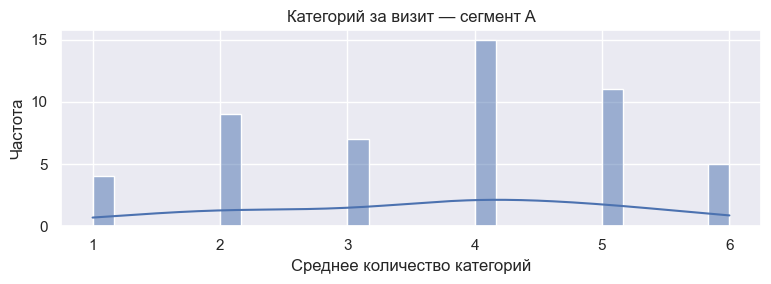

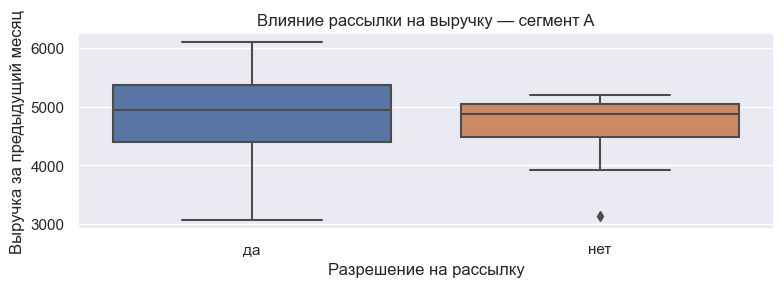

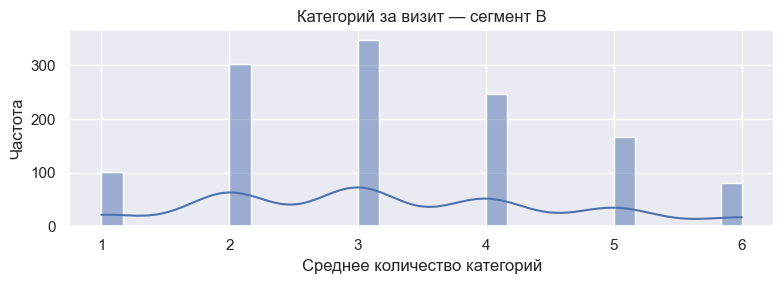

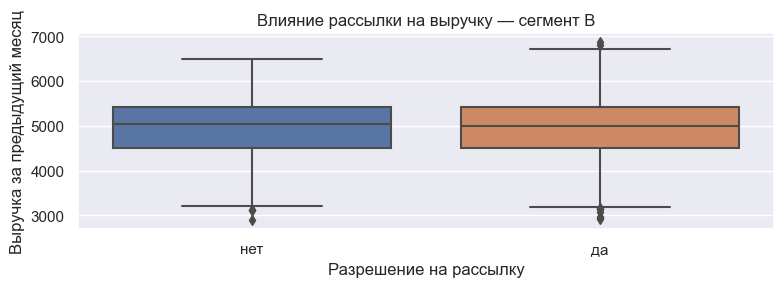

In [55]:
segment_a = df_merged[df_merged['сегмент'] == 'A']
segment_b = df_merged[df_merged['сегмент'] == 'B']
segments = [("A", segment_a), ("B", segment_b)]

for name, segment in segments:
    # Гистограмма: сколько категорий просматривают за визит
    plt.figure(figsize=(8, 3))
    sns.histplot(segment['среднее_категорий_за_визит'], kde=True, bins=30)
    plt.title(f"Категорий за визит — сегмент {name}")
    plt.xlabel("Среднее количество категорий")
    plt.ylabel("Частота")
    plt.tight_layout()
    plt.show()
    
    # Boxplot: влияние рассылки на выручку
    plt.figure(figsize=(8, 3))
    sns.boxplot(data=segment, y='выручка_предыдущий_месяц', x='разрешение_рассылки')
    plt.title(f"Влияние рассылки на выручку — сегмент {name}")
    plt.xlabel("Разрешение на рассылку")
    plt.ylabel("Выручка за предыдущий месяц")
    plt.tight_layout()
    plt.show()

## Промежуточный вывод

На данном этапе клиенты были разделены на 2 сегмента:
1. А - наиболее активные
2. В - менее активные

Сегмент B представляет больший интерес. Судя по оси "Частота" на гистограмме "Категорий за визит", сегмент B значительно крупнее сегмента A. Работа с более крупным сегментом может дать больший экономический эффект. Гистограмма показывает, что наибольшее количество покупателей в Сегменте B просматривают в среднем 3 категории за визит. Большинство клиентов в этом сегменте не склонны к широкому изучению ассортимента за один визит. Они фокусируются на небольшом количестве категорий. Это может означать, что они либо целенаправленно ищут что-то конкретное, либо им сложно ориентироваться и находить новые интересные для них товары. Клиенты, не подписанные на рассылку, в среднем приносят больше выручки. Текущие рассылки могут быть неэффективны для подписчиков Сегмента B и не стимулируют их тратить больше. 

# Общий вывод

1. Описание задачи

Основной задачей проекта являлась разработка модели машинного обучения для прогнозирования снижения покупательской активности постоянных клиентов интернет-магазина «В один клик» в ближайшие три месяца. Цель – использование этих прогнозов для персонализации предложений, повышения вовлечённости и лояльности клиентов. В исследование также были включены данные о прибыльности каждого клиента за последние три месяца для более точной сегментации и разработки целевых маркетинговых стратегий.

2. Описание исходных данных и проведённой предобработки

Для решения задачи были использованы данные из нескольких источников, описывающие различные аспекты поведения клиентов и их взаимодействия с магазином.
В ходе работы были выполнены следующие шаги предобработки:

- Загрузка и первичный анализ: Импортированы необходимые библиотеки, загружены данные. Пропуски в данных отсутствовали. Была исправлена ошибка с разделителем в файле money.csv, а названия всех признаков приведены к единому стилю (snake_case).
- Устранение дубликатов и ошибок: Явные дубликаты не обнаружены. Были исправлены неявные дубликаты и ошибки в написании в признаках "тип_сервиса", "популярная_категория" (в data_market_file) и "период" (в data_market_money и data_market_time).
- Фильтрация данных: Для анализа были отобраны клиенты с покупательской активностью не менее трёх месяцев.
  
`Исследовательский анализ данных (EDA):`
- Общая активность и вовлеченность: 61.8% клиентов сохраняют прежний уровень активности. Около 28.9% пользуются премиальным обслуживанием, и почти 74% согласны на получение маркетинговых предложений. Средняя маркетинговая активность (как за 6 месяцев, так и в текущем) составляет около 4 единиц. Новых пользователей не наблюдалось более трёх месяцев.
- Покупательское поведение: Большинство клиентов (доля от 0.18 до 0.3) совершают покупки по акциям; очень малая доля игнорирует их. Самая популярная категория – "Товары для детей" (25.4%), наименее популярная – "Кухонная посуда" (10.6%). В среднем клиенты просматривают 3 категории и около 8 страниц за визит (большинство – от 5 до 11). Среднее количество неоплаченных товаров в корзине – около 3, а среднее количество сбоев сервиса – 4.
- Финансовые показатели и время на сайте: Только треть клиентов совершила покупки в текущем месяце. Средняя выручка за период составила около 5000 у.е. Среднее время, проводимое пользователями на сайте, – около 13 минут. За последние три месяца средняя прибыль от одного покупателя составила 4 у.е.
- Объединение и агрегация данных: Таблицы market_file.csv, market_money.csv и market_time.csv были объединены. Данные в data_market_money были агрегированы по клиенту и периоду с использованием среднего значения из-за наличия множественных записей.
- Корреляционный анализ: Выявлена умеренная корреляция (0.72) между выручка_предыдущий_месяц и выручка_текущий_месяц; проверка VIF (значения ~2.1) показала приемлемый уровень мультиколлинеарности. Также отмечены положительные связи между страниц_за_визит и время_предыдущий_месяц (0.42), время_предыдущий_месяц и время_текущий_месяц (0.35), маркетинговая_активность_6мес и страниц_за_визит (0.31), и отрицательная связь между доля_акционных_покупок и страниц_за_визит (-0.31).

3. Поиск лучшей модели

Для прогнозирования снижения покупательской активности были рассмотрены четыре модели: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression и SVC. Обучение проводилось с использованием единого конвейера (pipeline), включающего масштабирование числовых признаков, и инструмента подбора гиперпараметров.
Из данных были исключены признаки маркетинговая_активность_текущий_мес, выручка_текущий_месяц и время_текущий_месяц во избежание утечки данных, так как они отражают активность клиента в прогнозируемом периоде.
В качестве основной метрики качества была выбрана ROC AUC, так как она хорошо подходит для задач с несбалансированными классами и оценивает общую способность модели к ранжированию.

4. Лучшая модель

`Наилучшие результаты показала модель SVC (Support Vector Classifier) со следующими характеристиками:`

- Гиперпараметры: kernel='linear', C=1000

- Предобработка: масштабирование числовых признаков с помощью MinMaxScaler

- Метрика качества: ROC AUC = 0.891

5. Выводы и дополнительные предложения для выбранного сегмента покупателей

`Анализ важности признаков с помощью SHAP-значений для лучшей модели показал:`

- Наиболее значимые признаки: num__среднее_категорий_за_визит (положительное влияние), num__время_предыдущий_месяц (положительное влияние), num__доля_акционных_покупок, num__страниц_за_визит, num__маркетинговая_активность_6мес и num__неоплаченные_товары_квартал (отрицательное влияние).
- Менее значимые признаки: Категориальные признаки популярных категорий (например, ohe__популярная_категория_Кухонная посуда, ohe__популярная_категория_Косметика и аксессуары и др.), num__выручка_предыдущий_месяц и num__ошибки_сервиса.

Эти данные важны как для дальнейшего улучшения модели (например, путем отсева малозначимых признаков или генерации новых), так и для бизнес-решений: стимулирования просмотра большего числа категорий и страниц, анализа эффективности акций, решения проблемы неоплаченных товаров и оптимизации маркетинговых кампаний.

На основе анализа клиенты были разделены на два сегмента: А (наиболее активные) и B (менее активные). Для углубленного анализа и разработки предложений был выбран Сегмент B как более крупный и обладающий большим потенциалом для роста.

`Характеристики и проблемы сегмента B:`

- Клиенты в этом сегменте в основном просматривают небольшое количество категорий за визит (пик на 3 категориях), что указывает либо на целенаправленный поиск, либо на трудности с навигацией и обнаружением новых товаров.

`Предложения для сегмента B:`

Стимулирование исследования большего числа категорий:

- Улучшить систему рекомендаций на сайте ("С этим товаром также покупают", "Вам может понравиться").
- Внедрить тематические подборки и гиды по товарам.
- Оптимизировать навигацию для легкого перехода между категориями.